# Сохранение и загрузка моделей

В этом блокноте показано, как сохранять и загружать модели с помощью PyTorch. Это важно, поскольку вам часто захочется загружать ранее обученные модели для использования в прогнозах или для продолжения обучения на новых данных.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

c:\Users\user1\anaconda3\envs\YOLO\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\user1\anaconda3\envs\YOLO\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Определим трансформацию для нормализации данных
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Загружаем обучающие данные
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Загружаем тестовые данные
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Отобразим одно из изображений.

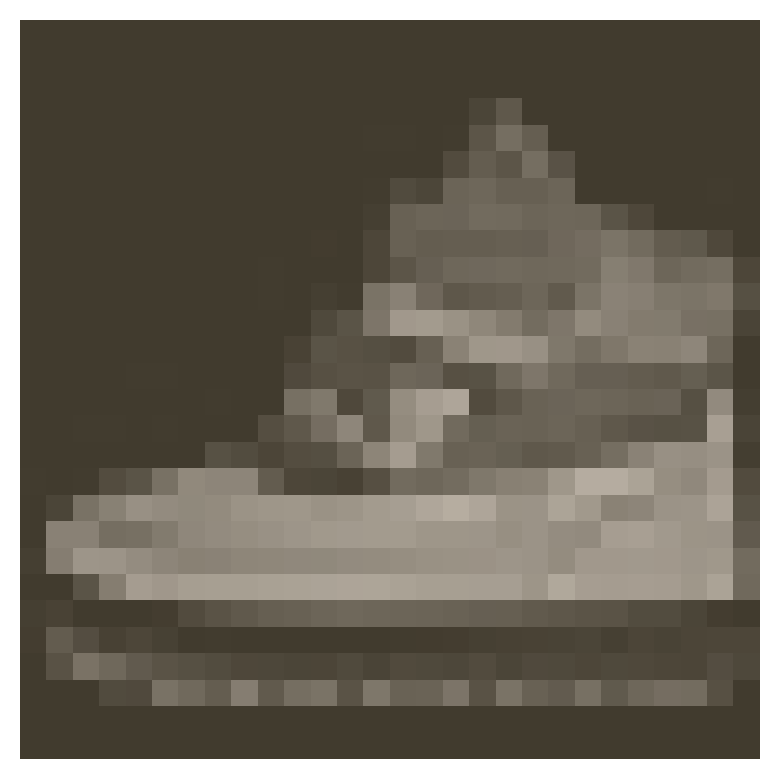

In [3]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

# Обучение сети

Чтобы сделать изложение более кратким, архитектура модели и код обучения перенесены из последней части в файл `fc_model`. Импортируя его, мы можем легко создать полносвязную сеть с помощью `fc_model.Network` и обучить сеть, используя `fc_model.train`. Будет использоваться эта модель (после её обучения), чтобы продемонстрировать, как можно сохранять и загружать модели.

In [4]:
# Создаем сеть, определяем функцию потерь и оптимизатор
model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.701..  Test Loss: 1.031..  Test Accuracy: 0.609
Epoch: 1/2..  Training Loss: 1.098..  Test Loss: 0.780..  Test Accuracy: 0.710
Epoch: 1/2..  Training Loss: 0.868..  Test Loss: 0.696..  Test Accuracy: 0.734
Epoch: 1/2..  Training Loss: 0.797..  Test Loss: 0.632..  Test Accuracy: 0.760
Epoch: 1/2..  Training Loss: 0.754..  Test Loss: 0.627..  Test Accuracy: 0.757
Epoch: 1/2..  Training Loss: 0.718..  Test Loss: 0.600..  Test Accuracy: 0.763


KeyboardInterrupt: 

## Сохранение и загрузка сетей

Как вы можете понять, нецелесообразно обучать сеть каждый раз, когда вам нужно её использовать. Вместо этого мы можем сохранить обученные сети, а затем загрузить их позже, чтобы продолжить обучение или использовать для прогнозов.

Параметры сетей в PyTorch хранятся в `state_dict` модели. Мы можем увидеть, что state dict содержит матрицы весов и смещений для каждого из наших слоёв.

In [6]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


Простейшее действие - просто сохранить state dict с помощью `torch.save`. Например, мы можем сохранить его в файл `'checkpoint.pth'`.

In [7]:
torch.save(model.state_dict(), 'checkpoint.pth')

Затем мы можем загрузить state dict с помощью `torch.load`.

In [8]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


А чтобы загрузить state dict в сеть, нужно сделать `model.load_state_dict(state_dict)`.

In [9]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Это кажется довольно простым, но, как обычно, это чуть сложнее. Загрузка state dict работает только если архитектура модели точно такая же, как архитектура чекпоинта (checkpoint). Если создать модель с другой архитектурой, это приведёт к ошибке.

In [10]:
# Попробуем это сделать
model = fc_model.Network(784, 10, [400, 200, 100])
# Это вызовет ошибку, потому что размеры тензоров неверны!
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param with shape torch.Size([512, 784]) from checkpoint, the shape in current model is torch.Size([400, 784]).
	size mismatch for hidden_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for hidden_layers.1.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for hidden_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for hidden_layers.2.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([100, 200]).
	size mismatch for hidden_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for output.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 100]).

Это означает, что нам нужно точно восстановить модель так, как она была при обучении. Информация об архитектуре модели должна быть сохранена в контрольной точке вместе с state dict. Для этого вы создаёте словарь со всей информацией, необходимой для полного восстановления модели.

In [11]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Теперь контрольная точка содержит всю необходимую информацию для восстановления обученной модели. Вы можете легко сделать это функцией, если хотите. Аналогично, мы можем написать функцию для загрузки контрольных точек.

In [12]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [13]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
